In [21]:
import requests
import matplotlib.pyplot as plt
from ftplib import FTP
import pandas as pd
import numpy as np
import os

In [22]:
def generate_list_of_files(key):
    yy = 0
    ffiles = []
    while yy < 23:    
        fname = key + str(yy).zfill(2) + '.01'
        ffiles.append(fname) 
        fname = key + str(yy).zfill(2) + '.07'        
        ffiles.append(fname)         
        yy += 1  
    return ffiles

In [23]:
def blocks(files, size=65536):
    while True:
        b = files.read(size)
        if not b: break
        yield b
 
def copyfromftp(key, dir_path):
    ftp = FTP()
    HOST = 'ftp2.bipm.org'
    PORT = 21
    ftp.connect(HOST, PORT)
    ftp.login()

    if key == 'w':
        ftp.cwd('/pub/tai/other-products/weights/')        
    elif key == 'd':
        ftp.cwd('/pub/tai/other-products/clkdrifts/')        
    else:
        return []
    
    ftp_files = []
    try:
        ftp_files = ftp.nlst()
    except FTP.error_perm as resp:
        if str(resp) == "550 No files found":
            print("No files in this directory")
        else:
            raise
    
    already_copied = os.listdir(dir_path)
    required_files = generate_list_of_files(key)
    new_copied = []
    for fname in ftp_files:
        if fname in required_files and fname not in already_copied:
            with open(dir_path+fname, 'wb') as f:
                ftp.retrbinary('RETR '+fname, f.write)
                f.close()
                new_copied.append(fname)
    ftp.quit()
    
    return new_copied

In [24]:
#dir_path = 'drifts/'
#key = 'd'
dir_path = 'weights/'
key = 'w'
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    
files = copyfromftp(key, dir_path)
if len(files) > 0:
    print(files)

In [25]:
def fproc(fname):    
    df = pd.DataFrame({'lab':[],'type':[], 'code':[]})
    try: 
        num_of_lines = 0    
        with open(fname, "r", encoding="utf-8", errors='ignore') as f:
            num_of_lines = sum(bl.count("\n") for bl in blocks(f))    
            
        ind_list = []        
        i = 0
        flag = 0
        with open(fname, "r", encoding="utf-8", errors='ignore') as f:
            for line in f:
                if flag == 0:
                    if "DENOTES THAT" in line:
                        flag = 1
                    ind_list.append(i)
                if ("RELATIVE WEIGHTS" in line or "LAB." in line 
                    or "             " in line):
                    ind_list.append(i)
                if "LAB." in line:
                    mjdline = line
                if ("Total weight" in line or "The clocks are designated" in line 
                    or "The clocks codes are defined" in line):
                    end_ind = i
                i += 1
        mjds = mjdline.split()
        #print(mjds)
        for i in range(end_ind, num_of_lines):
            ind_list.append(i)    
    
        df = pd.read_csv(fname, sep=' ', index_col=False, skip_blank_lines=True, skipinitialspace=True, skiprows=ind_list, on_bad_lines='skip',
                     na_values=['*****', '*********'], names=['lab', 'type', 'code', mjds[2], mjds[3], mjds[4], mjds[5], mjds[6], mjds[7], 'x']).fillna(0)
        df = df.drop('x', axis=1)
        df = df[df.lab != 0]
        df['code'] = df['type'].astype(int).astype(str) + df['code'].astype(int).astype(str)
        df['code'] = df['code'].astype(int)
    except Exception as e:
        print(e)
    return df

In [26]:
def compareMasers(df, listOfModels, modelNames):
    header = list(df)
    df['model'] = df['code'].apply(lambda x: str(x)[2:4] if str(x)[0:2]=="41" else 0)
    df['model'] = df['model'].astype(int)
    mjds = header[-12*2:-1]
    prod_for_models = []
    codes_for_models = []    
    num_for_models = []
    
    for clck_model in listOfModels:
        codes = []
        prod = []
        num = []        
        for mjd in mjds:
            tmp = df[(df['model'] == clck_model) & (df[mjd] != 0) & (np.abs(df[mjd]) < 100)]
            codes.extend(list(tmp['code']))
            prod.append(np.mean(tmp[mjd]))
            #prod.append(np.std(tmp[mjd]))
            #prod.append(np.mean(np.abs(tmp[mjd])))
            num.append(len(tmp[mjd]))        
        codes_for_models.append(set(codes))
        prod_for_models.append(prod)
        num_for_models.append(num)            

    plt.figure(1)
    plt.title('Aveage clock weights in TAI, %')
    #plt.title('Mean absolute value of clock drifts, ns/day/30days')    
    for i in range(len(listOfModels)):
        plt.plot(mjds, prod_for_models[i])
    plt.xticks(rotation=45)
    plt.legend(modelNames)
    plt.figure(2)
    plt.title('Number of clocks participating in TAI')
    for i in range(len(listOfModels)):
        plt.plot(mjds, num_for_models[i])
    plt.legend(modelNames)
    plt.xticks(rotation=45)
    
    return prod_for_models, codes_for_models, num_for_models, mjds

'utf-8' codec can't decode byte 0x93 in position 196: invalid start byte


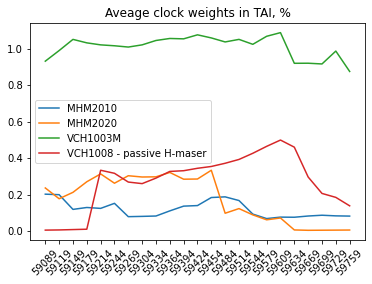

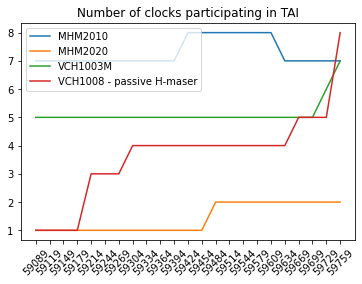

In [27]:
files = []
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        files.append(path)

ffiles = generate_list_of_files(key)
    
df = pd.DataFrame({'lab':[],'type':[], 'code':[]})
for fname in ffiles:
    if key in fname:
        df1 = fproc(dir_path+fname)
        df = df.merge(df1, how='outer', on=['code', 'lab', 'type']).fillna(0)

listOfModels = [20, 21, 53, 52]
namesOfModels = ['MHM2010', 'MHM2020', 'VCH1003M', 'VCH1008 - passive H-maser']
prod_for_models, codes_for_models, num_for_models, mjds = compareMasers(df, listOfModels, namesOfModels)